# Semantic segmentation with *Segmenter* #

### To fine-tune a model using *Segmenter*, we need to follow three steps: ###
1. initialize torch dataset
2. initialize backbone
3. initialize model with *Segmenter*

after these steps the model can be fitted


In [ ]:
from Segmenter import Segmenter
from Dataset_classes.ImageSegmentationDataset import ImageSegmentationDataset
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.io import read_image
import pytorch_lightning as pl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as sm

#### 1. initialize torch datasets ####
**I will use a dataset that reads image paths, converts mask [h, w, 3] to one-hot encoded mask [c, h, w]**


In [2]:
colors = {
    0: (0, 0, 0),
    1: (255, 0, 0),
    2: (128, 255, 128),
    3: (0, 0, 255),
    4: (255, 255, 0),
    5: (0, 255, 255),
    6: (255, 0, 255)
}


data = pd.read_csv('segmentation.csv')
data = data
data_t, data_v = train_test_split(data, train_size=0.8)
pred_data = pd.read_csv('segments2.csv')


normalize = T.Normalize(mean=[0.3965, 0.3658, 0.3250], std=[0.2427, 0.2399, 0.2376]) # if you don't know how to get the mean and std check the last cell
train_dataset = ImageSegmentationDataset(data_t, normalize, colors, shuffle=True)
val_dataset = ImageSegmentationDataset(data_v, normalize, colors, shuffle=True)
pred_dataset=ImageSegmentationDataset(pred_data, normalize, colors, with_target=False)

#### 2. initialize backbone ####
I will use DeepLabV3Plus from [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch)

In [3]:
backbone = sm.DeepLabV3Plus('resnet101', encoder_weights='imagenet', classes=7, activation = 'softmax')

#### 3. initialize model with *Segmenter* ####

In [4]:
model = Segmenter(backbone, nn.CrossEntropyLoss(), 1e-3, train_dataset, val_dataset, 'multilabel', num_labels=7, batch_size=10, pred_torch_dataset= pred_dataset)

#### Now we can fit the model ####

In [ ]:
torch.set_float32_matmul_precision('medium')
trainer = pl.Trainer(
    accelerator='gpu',
    min_epochs=1,
    max_epochs=1,
)

trainer.fit(model)


## addition ##
**get the predictions**

In [8]:
import matplotlib.pyplot as plt
from gray2color import gray2color

In [9]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)

    img = T.ToPILImage()(imgs[0])
    axs[0, 0].imshow(np.asarray(img))
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    mask = T.ToPILImage()(imgs[1])
    axs[0, 1].imshow(np.asarray(mask))
    axs[0, 1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\users\dimap\pycharmprojects\simple_binary_segmentation\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\users\dimap\pycharmprojects\simple_binary_segmentation\venv\lib\site-packages\pytorch_lightning\utilities\data.py:127: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(


Predicting DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

c:\users\dimap\pycharmprojects\simple_binary_segmentation\venv\lib\site-packages\segmentation_models_pytorch\base\modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]
3


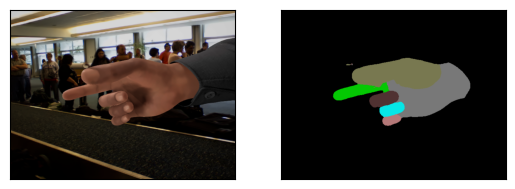

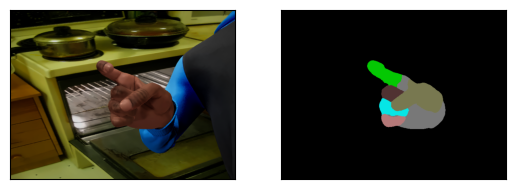

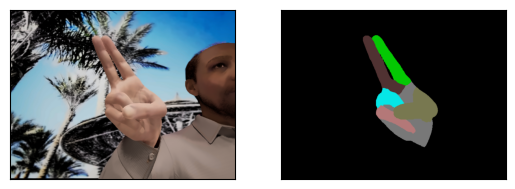

In [10]:

images = trainer.predict(model)
print(len(images))

list_of_true_mask = list(pred_data['image'])

for i, mask in enumerate(images):
    mask = torch.squeeze(mask)
    mask = torch.argmax(mask, dim=0)
    mask = np.asarray(mask, dtype='uint8')
    mask = gray2color(mask)

    true_mask = read_image(list_of_true_mask[i])
    show([true_mask, mask])

In [ ]:
from tqdm import tqdm
data = pd.read_csv('segmentation.csv')
dataloader = ImageSegmentationDataset(data, colors, with_target=False) # comment out the normalization line
mean = 0.0
std = 0.0

for images, _ in tqdm(dataloader):
    # Flatten the images
    images = images.view(images.size(0), -1)
    # Compute the mean and standard deviation
    mean += images.mean(1)
    std += images.std(1)

mean /= len(dataloader)
std /= len(dataloader)

print(f'mean is {mean}')
print(f'std is {std}')